In [1]:
from google.cloud import aiplatform
from langchain_google_vertexai import VertexAIEmbeddings
import os
from google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint import (
    Namespace,
    NumericNamespace,
)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\itsup\Downloads\dashtest-472304-2293013ef343.json"
# TODO : Set values as per your requirements
# Project and Storage Constants
PROJECT_ID = "dashtest-472304"
REGION = "europe-west4"
BUCKET = "regulations-vector-search"
BUCKET_URI = f"gs://{BUCKET}"

# The number of dimensions for the textembedding-gecko@003 is 768
# If other embedder is used, the dimensions would probably need to change.
DIMENSIONS = 768

# Index Constants
DISPLAY_NAME = "regulation-index-2"
DEPLOYED_INDEX_ID = "299753258010804224"


In [2]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI) 

In [3]:
embedding_model = VertexAIEmbeddings(model_name="text-embedding-005")

d:\GenAI-Hackathon\.venv\Lib\site-packages\vertexai\_model_garden\_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


In [4]:
# TODO : replace 1234567890123456789 with your acutial index ID
my_index = aiplatform.MatchingEngineIndex(index_name="projects/513267201789/locations/europe-west4/indexes/299753258010804224")

my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint(index_endpoint_name="projects/513267201789/locations/europe-west4/indexEndpoints/8262363689806462976")

In [5]:
from langchain_google_vertexai import (
    VectorSearchVectorStore,
    VectorSearchVectorStoreDatastore,
)

In [6]:
vector_store = VectorSearchVectorStore.from_components(
    project_id=PROJECT_ID,
    region=REGION,
    gcs_bucket_name=BUCKET,
    index_id=my_index.name,
    endpoint_id=my_index_endpoint.name,
    embedding=embedding_model,
    stream_update=True,
)


In [7]:
# vector_store.similarity_search("What does IEC 62304 section 5.1 say about software development planning?")

In [43]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import PyPDF2

In [44]:
with open(r"C:\Users\itsup\Downloads\IMDRF_SaMD WG_Software-Specific Risk_N81 Final_0 - converted-final.pdf", 'rb') as pdf_file:
    reader = PyPDF2.PdfReader(pdf_file)
    pages_text = []
    for page in reader.pages:
        pages_text.append(page.extract_text())


In [45]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024,   # adjust as needed
    chunk_overlap=200
)

In [46]:
import re

def clean_text(text: str) -> str:
    if not text:
        return ""

    # 1. Remove non-ASCII characters (unicode junk like \uf8e9)
    text = text.encode("ascii", "ignore").decode()

    # 2. Split into lines for fine-grained filtering
    cleaned_lines = []
    for line in text.split("\n"):
        line = line.strip()

        if not line:
            continue

        # Skip page headers/footers like "– 36 – IEC 62304:2006"
        if re.match(r"^–?\s*\d+\s*–?\s*IEC 62304", line):
            continue

        # Skip page numbers
        if re.fullmatch(r"\d+", line):
            continue

        # Skip copyright lines
        if re.search(r"(IEC|ISO|FDA).*20\d{2}", line):
            continue

        # Skip TOC dots/dashes/backticks like "......", "-----", "```"
        if re.match(r"^[\.\-`,]{3,}$", line):
            continue

        cleaned_lines.append(line)

    # 3. Join lines back
    text = " ".join(cleaned_lines)

    # 4. Fix hyphenated words broken across lines ("test-\ning" → "testing")
    text = re.sub(r"(\w+)-\s+(\w+)", r"\1\2", text)

    # 5. Remove leftover long runs of punctuation (`,,,`, "```", "---")
    text = re.sub(r"[\-`',\.]{3,}", " ", text)

    # 6. Collapse multiple spaces
    text = re.sub(r"\s+", " ", text)

    return text.strip()


In [47]:
# Collect chunks with metadata
DOC_NAME= "FDA"
docs = []
for page_num, page in enumerate(reader.pages, start=1):
    page_text = page.extract_text()
    if not page_text:
        continue
    page_text = clean_text(page_text)
    chunks = text_splitter.split_text(page_text)
    
    if chunks:
        for chunk in chunks:
            docs.append({
                "page_content": chunk,
                "metadata": {
                    "doc_name": DOC_NAME,
                    "page_number": page_num
                }
            })

In [48]:
docs[14]["page_content"]

'aims to establish harmonized concepts, considerations, and common vocabulary for the risk characterization of medical device software . Additional work may be required to apply and align these concepts in a given jurisdiction.'

In [49]:
vector_store.add_texts(
    texts=[d["page_content"] for d in docs],
    metadatas=[d["metadata"] for d in docs]
)

Upserting datapoints MatchingEngineIndex index: projects/513267201789/locations/europe-west4/indexes/299753258010804224
MatchingEngineIndex index Upserted datapoints. Resource name: projects/513267201789/locations/europe-west4/indexes/299753258010804224


['9da70b92-4118-4115-960d-05dada74191d',
 'f3b4739a-8061-4204-a9e8-28bf76b2cc61',
 '271af221-bb79-4ac9-83d1-93ac0f9b8c7b',
 'b0b725f9-76d5-4b6a-a61d-f10c7923c881',
 '9721c549-fc7e-4981-b1b6-6ad381806b84',
 'e1aa8bfb-4cda-48e3-ac8f-ac24c69bcb1c',
 '430ecf30-c8b0-4222-bcd5-064cb0659bbd',
 '50c98d26-a329-4f00-886d-32736c4947de',
 'a51943a1-f3a2-44e2-88dd-772727936c5b',
 'a961c43c-3dd0-4f20-acf0-705653aed686',
 'dcc232a4-349d-433f-8bb7-c0f9f029f3fd',
 '14216326-af0d-45e5-8745-4268b0cea6d1',
 'c5851ace-c7d9-4c99-bf17-98461a35d3d6',
 '224c6392-5a13-4aba-a049-67dfc06dbeb7',
 '096da480-884e-49c2-a94b-ca65f5c16ac3',
 '19ba9bdf-c152-401e-b026-91edda277287',
 'd8b1262c-6976-4c5c-a61c-c6e6a44f9921',
 '3ddc70e8-a8a8-4258-a7f0-c1eecb4f693e',
 'e23bdc4d-89f0-4086-a79d-814e4199fef4',
 '73d9d48e-90b9-456b-8658-d2c289e3c84e',
 '7a135d4f-9637-477d-b20c-8076459fca33',
 '3410a4c8-94b5-44f4-b58a-b95d1318ddf3',
 'a95defb7-17d5-434a-8dcc-464a74efe3b2',
 '5c2ce6dc-3c93-4e2d-8793-d9cd7a984103',
 '8dc31139-e460-

In [50]:
retriever = vector_store.as_retriever(search_kwargs={"k": 10})

In [21]:
retriever.invoke("According to IEC 62304, how should software modules be classified based on risk to patients?")


KeyboardInterrupt: 

In [ ]:
# from langchain.chains import RetrievalQA

# filters = [Namespace(name="season", allow_tokens=["spring"])]
# numeric_filters = [NumericNamespace(name="price", value_float=40.0, op="LESS")]

# retriever.search_kwargs = {"k": 2, "filter": filters, "numeric_filter": numeric_filters}

# retrieval_qa = RetrievalQA.from_chain_type(
#     llm=llm,
#     chain_type="stuff",
#     retriever=retriever,
#     return_source_documents=True,
# )

# question = "What are my options in breathable fabric?"
# response = retrieval_qa({"query": question})
# print(f"{response['result']}")
# print("REFERENCES")
# print(f"{response['source_documents']}")

In [68]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_google_community.vertex_rank import VertexAIRank

In [69]:
reranker = VertexAIRank(
    project_id=PROJECT_ID,
    location_id="global",
    ranking_config="default_ranking_config",
    title_field="source",
    top_n=5,
)

In [70]:
retriever_with_reranker = ContextualCompressionRetriever(
    base_compressor=reranker, base_retriever=retriever
)

In [71]:
filters = [Namespace(name="doc_name", allow_tokens=["IEC-62304"])]


In [72]:
query = ["According to IEC 62304, how should software modules be classified based on risk to patients?", "According to IEC 62304, how should software modules be classified based on risk to patients?"]
retrieved_docs = retriever.invoke(query,filter = filters)
reranked_docs = retriever_with_reranker.invoke(query,filter = filters )

TypeError: expected string or bytes-like object, got 'list'

In [66]:
retrieved_docs

[Document(id='ef7a7edf-cc69-40f4-86b6-4cb6aaf80134', metadata={'doc_name': 'IEC-62304', 'page_number': 5}, page_content='to meet European Directives . Software safety classification changes needed for this amendment include clarification of requirements and updating of the software safety classification to include a risk -based approach. Work is continuing in parallel to develop the second edition of IEC 62304. International Electrotechnical Commission Provided by IHS under license with IEC Licensee=Chongqing Institute of quality and Standardization 5990390 Not for Resale, 2015/8/20 09:23:13 No reproduction or networking permitted without license from IHS'),
 Document(id='dceff67b-a4fc-482a-9db6-cec7f4c47c5b', metadata={'doc_name': 'IEC-62304', 'page_number': 13}, page_content='4.3 * Software safety classification a) The MANUFACTURER shall assign to each SOFTWARE SYSTEM a software safety class (A, B, or C) according to the RISK of HARM to the patient, operator, or other people resultin

In [60]:
reranked_docs

[Document(metadata={'id': '1', 'relevance_score': 0.400299996137619, 'source': ''}, page_content='4.3 * Software safety classification a) The MANUFACTURER shall assign to each SOFTWARE SYSTEM a software safety class (A, B, or C) according to the RISK of HARM to the patient, operator, or other people resulting from a HAZARDOUS SITUATION to which the SOFTWARE SYSTEM can contribute in a worst -case - scenario as indicated in Figure 3. Figure 3 Assigning software safety classification The SOFTWARE SYSTEM is software safety c lass A if : the SOFTWARE SYSTEM cannot contribute to a HAZARDOUS SITUATION ; or the SOFTWARE SYSTEM can contribute to a HAZARDOUS SITUATION which does not result in unacceptable RISK after consideration of RISK CONTROL measures external to the SOFTWARE SYSTEM . The SOFTWARE SYSTEM is software safety c lass B if : the SOFTWARE SYSTEM can contribute to a HAZARDOUS SITUATION which results in unacceptable RISK after consideration of RISK CONTROL measures external to the SO

In [3]:
from app.services.llm_services.llm_implementation.gemini_models import Gemini25FlashLiteLLM, Gemini25FlashLLM
# from app.services.llm_services.graph_pipeline import GraphPipe, ComplianceGraphPipe

In [4]:
llm = Gemini25FlashLLM()

In [ ]:
# graph = ComplianceGraphPipe(llm=llm)
# com_graph = graph.compile_graph()
# from IPython.display import Image, display

# try:
#     display(Image(com_graph.get_graph().draw_mermaid_png()))
# except Exception:
#     # This requires some extra dependencies and is optional
#     pass

In [6]:
with open(r"C:\Users\91882\Downloads\prd1.txt", 'r') as f:
    user_input = f.read()

In [7]:
final_state = com_graph.invoke({"messages": [{"role": "user", "content": user_input}]})

 INFO : 2025-09-18 09:26:31,383 graph_pipeline.py:214 plan_comliance --> LLM Compliance Planning Completed
 INFO : 2025-09-18 09:26:31,387 graph_pipeline.py:222 compliance_answer --> Sending LLM Compliance Enrichment Request
 INFO : 2025-09-18 09:26:52,948 graph_pipeline.py:237 compliance_answer --> LLM Compliance Enrichment Completed
 INFO : 2025-09-18 09:26:57,715 graph_pipeline.py:222 compliance_answer --> Sending LLM Compliance Enrichment Request
 INFO : 2025-09-18 09:26:59,069 graph_pipeline.py:237 compliance_answer --> LLM Compliance Enrichment Completed
 INFO : 2025-09-18 09:27:02,790 graph_pipeline.py:222 compliance_answer --> Sending LLM Compliance Enrichment Request
 INFO : 2025-09-18 09:27:04,012 graph_pipeline.py:237 compliance_answer --> LLM Compliance Enrichment Completed
 INFO : 2025-09-18 09:27:08,587 graph_pipeline.py:222 compliance_answer --> Sending LLM Compliance Enrichment Request
 INFO : 2025-09-18 09:27:09,880 graph_pipeline.py:237 compliance_answer --> LLM Compl

In [11]:
print(final_state["messages"][-1].content)

Enriched Compliance Requirements:

**1. HIPAA Compliance**

*   **Standard Name:** HIPAA (45 CFR Part 164 - Security Rule, 45 CFR Part 164 - Privacy Rule, 45 CFR Part 162 - Electronic Transactions Rule, 45 CFR Part 164 - Breach Notification Rule)
*   **Clause/ID:** 45 CFR Part 164 (specifically Subparts C, D, and E), 45 CFR Part 162
*   **Requirement Title:** Protection of Protected Health Information (PHI) and Electronic Protected Health Information (ePHI), Electronic Transaction Standards, Audit Controls, Administrative, Physical, and Technical Safeguards, and Breach Notification Procedures.
*   **Requirement Text:** The HIPAA Security Rule (45 CFR Part 164, Subpart C) establishes national security standards to protect certain health information in electronic form, including financial data storage. The Privacy Rule (45 CFR Part 164, Subpart E) governs the uses and disclosures of protected health information. The Electronic Transactions Rule (45 CFR Part 162) mandates adherence to ele

In [1]:
from app.services.llm_services.tools.rag_tools import retrieve_by_standards

d:\GenAI-Hackathon\.venv\Lib\site-packages\vertexai\_model_garden\_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


In [2]:
retrieve_by_standards("IEC 62304 Software Development Process Clause 5, Software Configuration Management Process Clause 6, Software Maintenance Process Clause 7", "IEC")

 INFO : 2025-09-18 09:16:45,857 rag_tools.py:65 retrieve_by_standards --> RAG Tool Invoked with query: IEC 62304 Software Development Process Clause 5, Software Configuration Management Process Clause 6, Software Maintenance Process Clause 7 and standard: IEC-62304
 INFO : 2025-09-18 09:16:54,130 rag_tools.py:76 retrieve_by_standards --> RAG Tool Retrieved 5 documents


"[{'query': 'IEC 62304 Software Development Process Clause 5, Software Configuration Management Process Clause 6, Software Maintenance Process Clause 7', 'standard': 'IEC', 'contents': 'and VERIFICATION5.6 Software integration and integration testing6.2 Problem and modification analysis6.1 Establish software maintenance plan Figure 2 Overview of software maintenance PROCESSES and ACTIVITIES This standard identifies two additional PROCESSES considered essential for developing safe MEDICAL DEVICE SOFTW ARE. They are the softwar e configuration management PROCESS (Clause 8) and the software problem resolution PROCESS (Clause 9). Amendment 1 updates the standard to add requirements to deal with LEGACY SOFTWARE , where the software design is prior to the existence of the current version, to assist manufacturers who must show compliance to the standard to meet European Directives . Software safety IEC 722/06 IEC 72 3/06 International Electrotechnical Commission Provided by IHS under license 

In [1]:
from app.services.llm_services.graph_pipeline import GraphPipe
from app.services.llm_services.llm_implementation.gemini_models import Gemini25FlashLiteLLM, Gemini25FlashLLM
llm = Gemini25FlashLLM()

d:\GenAI-Hackathon\.venv\Lib\site-packages\vertexai\_model_garden\_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


In [2]:
graph = GraphPipe(llm = llm)
comp_graph = graph.compile_graph()

In [3]:
from IPython.display import Image, display

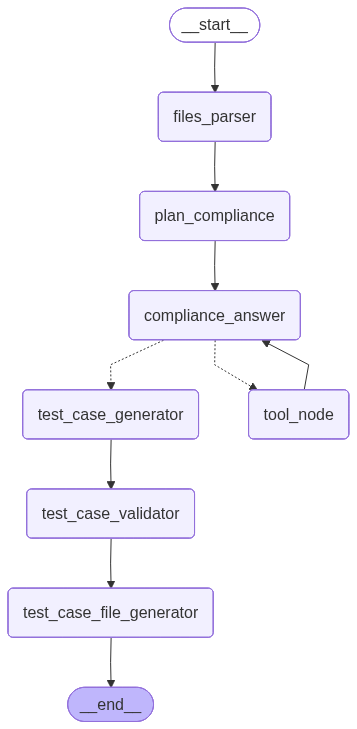

In [4]:
display(Image(comp_graph.get_graph().draw_mermaid_png()))